In [5]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_utils
from src import graph_utils
from src import inpaint_utils
from src import fiberatlas_utils

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

### Generating objects for comparison

In [9]:
root = '../../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'

for scale in range(4,5):
    # 1. Load fiber atlas informations
    connFilename = f'../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5'
    hf = h5py.File(connFilename, 'r')
    nsubject = hf.get('header').get('nsubjects')[()]
    fiber_affine = hf.get('header').get('affine')[()]
    gmregions_names = hf.get('header').get('gmregions')[()]
    nb_regions = gmregions_names.shape[0]
    gm_mask_subj = nib.load('../../atlas_data/moviedata_fMRI_eg/gm_mask_subj7.nii').get_fdata() 
    wm_mask_subj = (gm_mask_subj + 1) % 2
    thresh_subjapp = int(np.ceil(nsubject * 0.1)) 

    # 2. Create design matrix
    X = []
    bundles_labels = []
    for i in tqdm(range(1,nb_regions + 1)):
        for j in range(i,nb_regions + 1):
            tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
            if tmp is None: continue
            if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
            bundles_labels.append((i,j))
            vec = np.zeros(nb_regions)
            vec[i-1] = 1.0
            vec[j-1] = 1.0
            X.append(vec)

    X = np.array(X)

    atlas_of_interest = f'compresslausanne2018.scale{scale}.sym.corrected.ctx+subc.volspams.nii.gz'

    prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata()[:,:,:,1:], 
                                nib.load(root + atlas_of_interest).affine)

    Xp = []
    bundles_labels = []
    for i in tqdm(range(1,nb_regions + 1)):
        for j in range(i,nb_regions + 1):
            tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
            if tmp is None: continue
            if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
            bundle_coords = tmp[:,[0,1,2]]

            prob_vox = np.zeros_like(prob_regions[:,:,:,0])
            prob_vox[bundle_coords[:,0], bundle_coords[:,1], bundle_coords[:,2]] = 1.0

            region_i = prob_regions[:,:,:,i-1]
            region_j = prob_regions[:,:,:,j-1]

            bundle_proba_i = (region_i * prob_vox)
            bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
            bundle_proba_j = (region_j * prob_vox)
            bproba_j = bundle_proba_j[bundle_proba_j!=0].mean()

            bundles_labels.append((i,j))
            vec = np.zeros(nb_regions)
            vec[i-1] = bproba_i
            vec[j-1] = bproba_j
            Xp.append(vec)

    Xp = np.array(Xp)
    Xp = np.nan_to_num(Xp)

    # 3. Load fMRI
    region_ftimecourse = load(f"../../atlas_data/moviedata_fMRI_eg/yasseratlased_fmri/ftimecourse_95_scale{scale}.pkl")
    regions_in_voxels = load(f'../../atlas_data/fiber_atlas/regions95_voxels_scale{scale}.pkl')[:,:,:,1:]

    # 4. Optimizing to inpaint
    bundle_graph = np.zeros((X.shape[0], X.shape[0]))
    for k in range(X.shape[0]):
        avect1 = X[k]
        for s in range(X.shape[0]):
            if s == k: continue
            avect2 = X[s]
            if np.abs(avect1 - avect2).sum() <= 2:
                bundle_graph[k,s] = 1.0
                bundle_graph[s,k] = 1.0

    # temporal graph defining
    cycle = graph_utils.make_cycle(region_ftimecourse.shape[-1])

    Ls = graph_utils.compute_directed_laplacian(bundle_graph)
    Lt = graph_utils.compute_directed_laplacian(cycle)

    Xmult = np.array([Xp.T for _ in range(region_ftimecourse.shape[-1])])

    bundle_opt, logs = inpaint_utils.optimize_lreg(Xmult, region_ftimecourse, Ls=Ls, Lt=Lt, 
                                                verbose=True, num_epochs=200, logging=True, p1=0, p2=0, lr=1)

    save(f"../resources/weight_regressors_activity/vweighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}.pkl", bundle_opt)

    # 5. Retrieving bundles
    bundle_affine = np.array(hf.get('header').get('affine'))[()]

    voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
    vdim = voxel_fmri.shape[:3]
    rest_affine = voxel_fmri.affine

    trans_affine = np.matmul(np.linalg.inv(rest_affine), bundle_affine)

    fmri_coords = []
    for k in tqdm(range(len(bundles_labels))):
        i,j = bundles_labels[k]
        streamline = fiberatlas_utils.get_bundles_betweenreg(hf, i,j)
        streamline = streamline[streamline[:,3] >= thresh_subjapp]
        volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)
        volcoords_interest = np.concatenate([volcoords_interest, streamline[:,[3]]/nsubject], axis=1)

        fmri_coords.append(volcoords_interest)

    save(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl', fmri_coords)

    fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')

    # 6. Inpainting
    tmparray_lreg = []
    for k in tqdm(range(bundle_opt.shape[0])):
        tmp_inpainted, tmp_inpainted2 = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], vdim, wmmask=wm_mask_subj, normalizing=True, verbose=False)
        tmparray_lreg.append(tmp_inpainted)
    tmparray_lreg = np.array(tmparray_lreg)

    save(f'../resources/inpainted/scale{scale}_inpainteddiv{int(np.ceil(thresh_subjapp))}.pkl', tmparray_lreg)
    
    # NOTE: Close the opened h5 file
    hf.close()

In [13]:
for scale in range(1,4):

    connFilename = f'../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5'
    hf = h5py.File(connFilename, 'r')

    gmregions_names = hf.get('header').get('gmregions')[()]
    nb_regions = gmregions_names.shape[0]

    regions_in_voxels = load(f'../../atlas_data/fiber_atlas/regions95_voxels_scale{scale}.pkl')[:,:,:,1:]
    region_ftimecourse = load(f"../../atlas_data/moviedata_fMRI_eg/yasseratlased_fmri/ftimecourse_95_scale{scale}.pkl")

    tmparray_gm = []
    for tidx in tqdm(range(bundle_opt.shape[0])):
        frame0 = zscore(region_ftimecourse[:,tidx])/3
        gm_activity_voxels = np.sum([frame0[k] * regions_in_voxels[:,:,:,k] 
                                    for k in range(nb_regions)],axis=0)
        gm_activity_voxels[gm_activity_voxels==0] = -100
        tmparray_gm.append(gm_activity_voxels)
    tmparray_gm = np.array(tmparray_gm)

    save(f'../resources/inpainted/scale{scale}_gm.pkl', tmparray_gm)
    hf.close()


100%|██████████| 460/460 [10:01<00:00,  1.31s/it]


### Compute areas of good correlation against gray matter of each models

In [15]:
gm_activity = {}
reg_activity = {}
for scale in range(1,4):
    gm_activity[scale] = load(f'../resources/inpainted/scale{scale}_gm.pkl')
    reg_activity[scale] = load(f'../resources/inpainted/scale{scale}_inpainteddiv{int(np.ceil(thresh_subjapp))}.pkl')

In [19]:
def volume_similarity(A:np.ndarray, B:np.ndarray):
    """ 
    Compute similarity between two volumes



    """
    ret = np.zeros((A.shape[1:]))
    for x in range(ret.shape[0]):
        for y in range(ret.shape[1]):
            for z in range(ret.shape[2]):
                ret[x,y,z] = utils.pearsonr(A[:,x,y,z], B[:, x,y,z])[0]

    ret = np.nan_to_num(ret)
    ret[ret==0] = -100

    return ret

In [20]:
tmparray_voxel = []
tmpdata = voxel_fmri.get_fdata()
for tidx in range(bundle_opt.shape[0]):
    tmparray_voxel.append(tmpdata[:,:,:,tidx])
tmparray_voxel = np.array(tmparray_voxel)

In [21]:
similarity_gm_reg = {}
similarity_gm_voxel = {}
similarity_reg_voxel = {}

for scale in tqdm(range(1,4)):
    similarity_gm_reg[scale] = volume_similarity(gm_activity[scale], reg_activity[scale])
    similarity_gm_voxel[scale] = volume_similarity(tmparray_voxel, gm_activity[scale])
    similarity_reg_voxel[scale] = volume_similarity(tmparray_voxel, reg_activity[scale])

  0%|          | 0/3 [00:00<?, ?it/s]/home/chchan/miniconda3/envs/microstruct_atlas/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 3/3 [17:36<00:00, 352.22s/it]


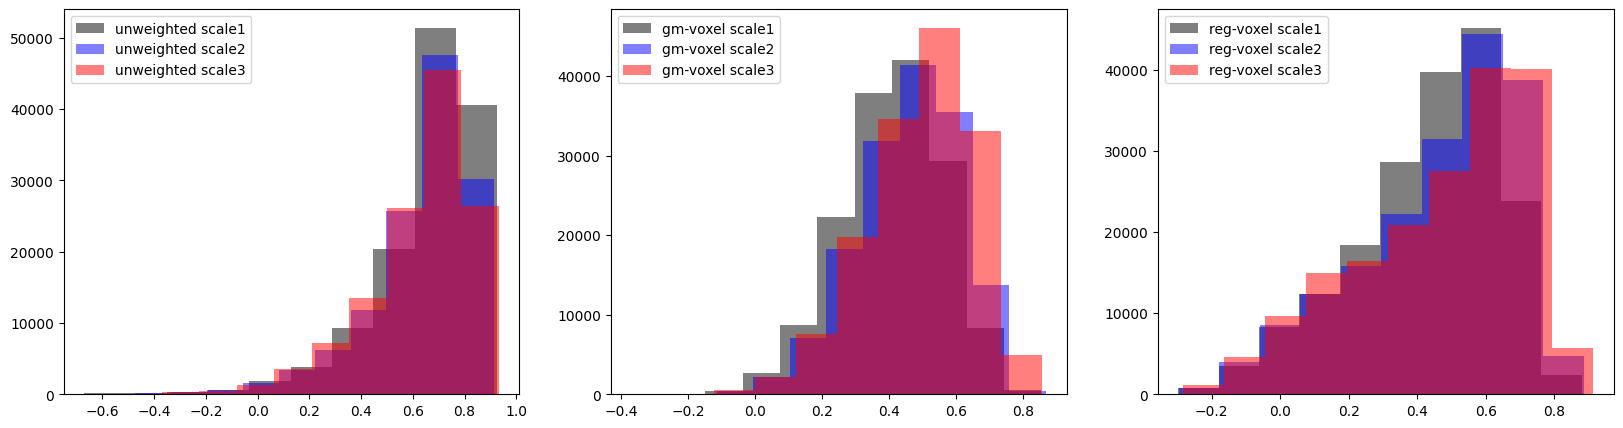

In [23]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
colors = ['k', 'b', 'r']
for scale in range(1, 4):

    ax[0].hist(similarity_gm_reg[scale][similarity_gm_reg[scale]!=-100], color=colors[scale-1], label=f'unweighted scale{scale}', alpha=0.5)
    ax[1].hist(similarity_gm_voxel[scale][similarity_gm_voxel[scale]!=-100], color=colors[scale-1], label=f'gm-voxel scale{scale}', alpha=0.5)
    ax[2].hist(similarity_reg_voxel[scale][similarity_reg_voxel[scale]!=-100], color=colors[scale-1], label=f'reg-voxel scale{scale}', alpha=0.5)


ax[0].legend()
ax[1].legend()
ax[2].legend()

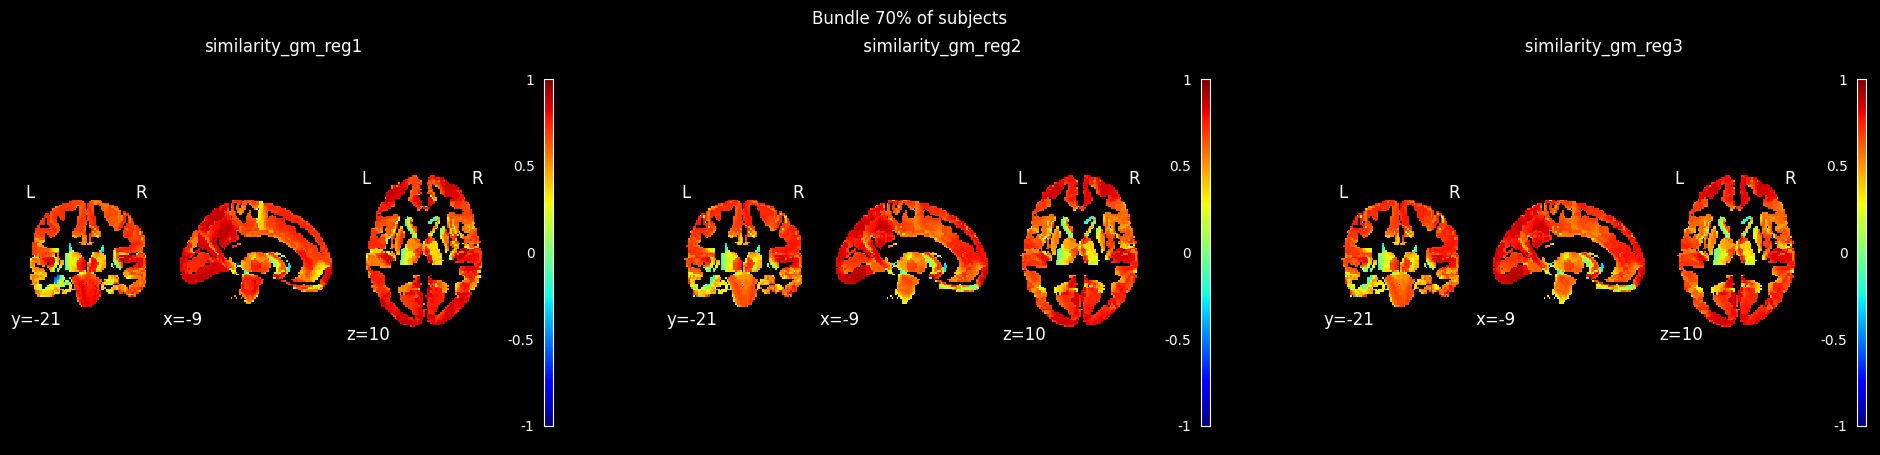

In [24]:
inpaint_mods = [similarity_gm_reg[1], similarity_gm_reg[2], similarity_gm_reg[3]]
all_inpaints_names = f'similarity_gm_reg{1}, similarity_gm_reg{2},   similarity_gm_reg{3}'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)

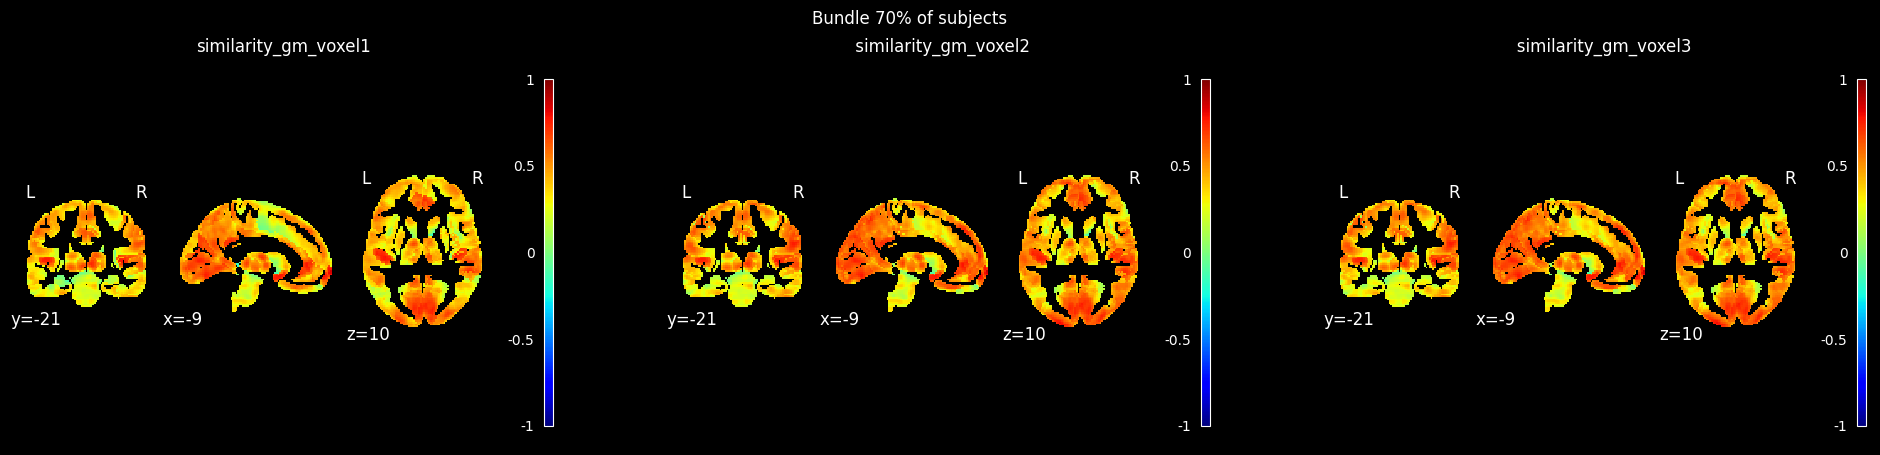

In [25]:
inpaint_mods = [similarity_gm_voxel[1], similarity_gm_voxel[2], similarity_gm_voxel[3]]
all_inpaints_names = f'similarity_gm_voxel{1}, similarity_gm_voxel{2},   similarity_gm_voxel{3}'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)

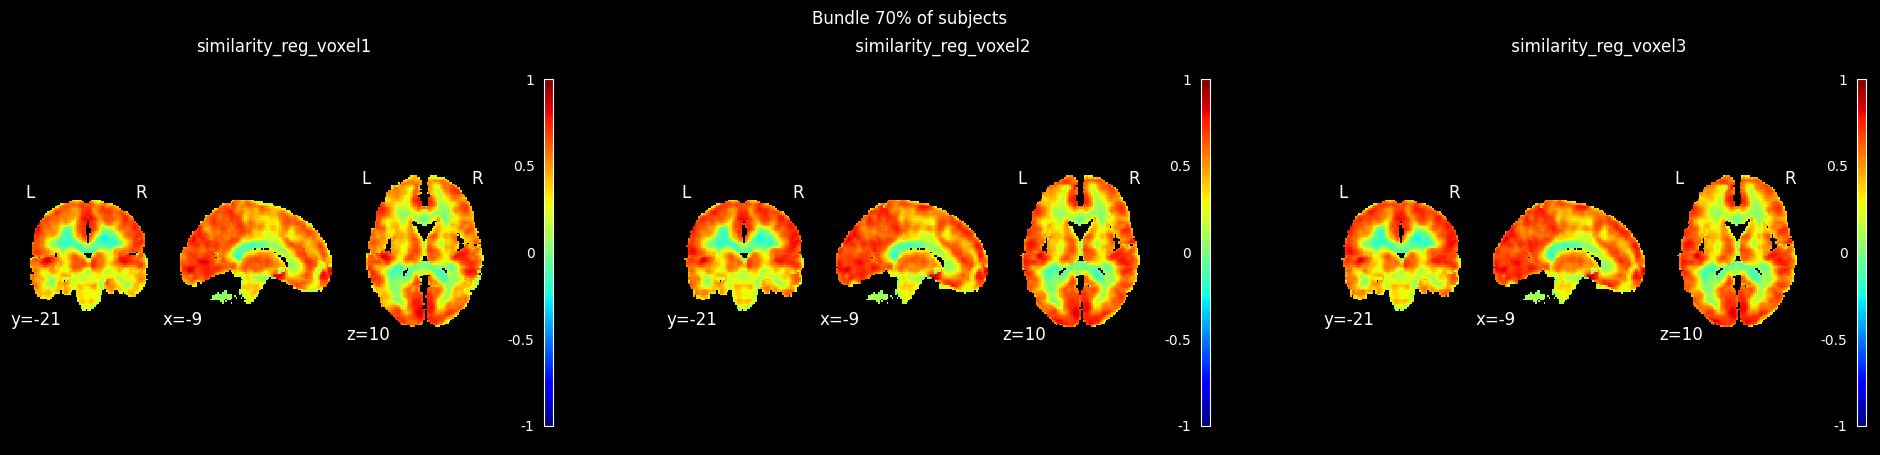

In [26]:
inpaint_mods = [similarity_reg_voxel[1], similarity_reg_voxel[2], similarity_reg_voxel[3]]
all_inpaints_names = f'similarity_reg_voxel{1}, similarity_reg_voxel{2}, similarity_reg_voxel{3}'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)